# Dual-Network Hydrogel Mastercurve

Auto TTS on dual-network hydrogels across temperature.

**Data:** examples/data/temperature_sweep/hydrogels/*.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell
from rheojax.models import HerschelBulkley

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


## Load multi-temperature sweeps (UTF-16)

In [3]:
# Find data directory - handle different CWD scenarios (IDE vs nbconvert)
import codecs
from io import StringIO

# Try multiple candidate paths for robustness
_data_path_candidates = [
    Path.cwd().parent / 'data' / 'temperature_sweep' / 'hydrogels',  # CWD = notebook dir
    Path.cwd() / 'examples' / 'verification' / 'data' / 'temperature_sweep' / 'hydrogels',  # CWD = project root
    Path.cwd() / 'examples' / 'data' / 'temperature_sweep' / 'hydrogels',  # CWD = project root (alt)
]

DATA_DIR = None
for _candidate in _data_path_candidates:
    if _candidate.exists() and len(list(_candidate.glob('*.csv'))) > 0:
        DATA_DIR = _candidate
        break

if DATA_DIR is None:
    raise FileNotFoundError(
        f"No CSV files found in any candidate path. CWD={Path.cwd()}\n"
        f"Tried: {[str(c) for c in _data_path_candidates]}"
    )

files = sorted(DATA_DIR.glob('*.csv'))
print(f"Found {len(files)} CSV files in {DATA_DIR}")

datasets = []
for fpath in files:
    stem = fpath.stem
    temp_token = stem.split('_')[-1]
    temp_c = float(temp_token.replace('c','').replace('h',''))
    
    # Read UTF-16 files using codecs (pandas has issues with UTF-16-LE)
    try:
        with codecs.open(fpath, 'r', encoding='utf-16') as f:
            content = f.read()
        # Skip header rows (0-10) + units row, data starts at row 12
        # Files have alternating blank lines so we filter them out
        df = pd.read_csv(StringIO(content), sep='\t', skiprows=11, 
                        names=['omega', 'Gp', 'Gpp'], decimal=',', skip_blank_lines=True)
    except Exception as e:
        print(f"Warning: Could not read {fpath.name}: {e}")
        continue
        
    df = df.dropna()
    df['omega'] = pd.to_numeric(df['omega'], errors='coerce')
    df['Gp'] = pd.to_numeric(df['Gp'], errors='coerce')
    df['Gpp'] = pd.to_numeric(df['Gpp'], errors='coerce')
    df = df.dropna()
    if df.empty:
        continue
    omega = df['omega'].to_numpy()
    Gp = df['Gp'].to_numpy()
    Gpp = df['Gpp'].to_numpy()
    datasets.append(RheoData(x=omega, y=Gp + 1j*Gpp, x_units='rad/s', y_units='Pa', domain='oscillation', metadata={'temperature': temp_c + 273.15, 'test_mode': 'oscillation'}))

if not datasets:
    raise ValueError("No valid datasets loaded from CSV files")
    
print(f"Loaded {len(datasets)} datasets")

mc = Mastercurve(reference_temp=298.15, method='wlf', auto_shift=True)
try:
    master, shifts = mc.create_mastercurve(datasets, return_shifts=True)
except Exception as exc:
    print(f"Auto-shift failed: {exc}; falling back to manual identity shifts")
    manual_shifts = {d.metadata['temperature']: 1.0 for d in datasets}
    mc = Mastercurve(reference_temp=298.15, method='manual', auto_shift=False)
    mc.set_manual_shifts(manual_shifts)
    master, shifts = mc.create_mastercurve(datasets, return_shifts=True)

print(f"Temps (C): {[round(d.metadata['temperature']-273.15,1) for d in datasets]}")
print(shifts)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


Found 15 CSV files in /Users/b80985/Projects/rheojax/examples/verification/data/temperature_sweep/hydrogels
Loaded 6 datasets


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.396181s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=0.0160 | elapsed=2.396s | final_gradient_norm=0.0016


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.456654s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=0.0050 | elapsed=0.457s | final_gradient_norm=2.2855e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.630056s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=0.0018 | elapsed=0.630s | final_gradient_norm=0.0184


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.679673s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=9.7304e-04 | elapsed=0.680s | final_gradient_norm=0.0037


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.410264s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=0.0010 | elapsed=0.410s | final_gradient_norm=0.0089


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.348758s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=5.2474e-04 | elapsed=0.349s | final_gradient_norm=0.0057


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.372404s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=4.2723e-04 | elapsed=0.372s | final_gradient_norm=2.5688e-05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.345811s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=2.0817e-04 | elapsed=0.346s | final_gradient_norm=0.0024


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.607461s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=0.0010 | elapsed=0.607s | final_gradient_norm=0.0011


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.455610s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=7.6872e-04 | elapsed=0.456s | final_gradient_norm=0.0127


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.456476s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=38 | final_cost=0.0126 | elapsed=0.456s | final_gradient_norm=2.4184e+05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-08 | xtol=1.0000e-08 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.437991s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=33 | final_cost=0.0088 | elapsed=0.438s | final_gradient_norm=1.2757e+04


Temps (C): [10.0, 10.0, 20.0, 30.0, 40.0, 50.0]
{283.15: np.float64(1.1147813481221043), 293.15: np.float64(1.0), 303.15: np.float64(2.0716235222245243), 313.15: np.float64(4013.571488572925), 323.15: np.float64(5966.780997629234)}


## Plot raw vs shifted

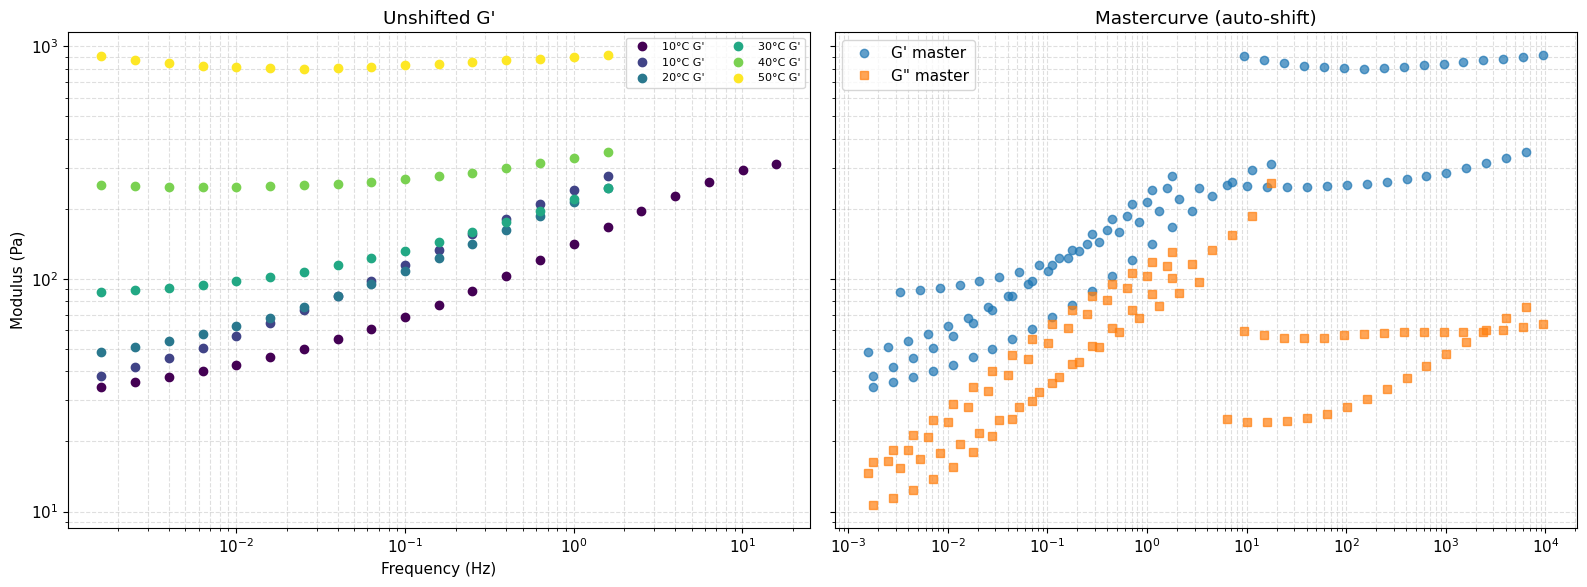

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))
for c, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x/(2*np.pi), np.real(data.y), 'o', color=c, label=f"{temp_c:.0f}°C G'")
axes[0].set_title("Unshifted G'")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x/(2*np.pi), np.real(master.y), 'o', label="G' master", alpha=0.7)
axes[1].loglog(master.x/(2*np.pi), np.imag(master.y), 's', label='G" master', alpha=0.7)
axes[1].set_title('Mastercurve (auto-shift)')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.562868s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=1.4067e+06 | elapsed=1.563s | final_gradient_norm=65.7514


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.612457s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=1.4067e+06 | elapsed=0.612s | final_gradient_norm=65.7514


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.921225s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.4080e+06 | elapsed=0.921s | final_gradient_norm=7.6989e+10


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.009513s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.4160e+06 | elapsed=1.010s | final_gradient_norm=1.7828e+11


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.956716s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=8 | final_cost=1.5050e+06 | elapsed=0.957s | final_gradient_norm=2.4604e+12


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.461945s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.5882e+06 | elapsed=0.462s | final_gradient_norm=9.2154e+09


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.860221s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=14.3000 | elapsed=1.860s | final_gradient_norm=0.0314


{'gm_r2': 0.5736802519113277, 'fm_r2': 0.33912668984295535}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 2 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.582348s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=2.0546e+04 | elapsed=0.582s | final_gradient_norm=2.5186e+07


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.650144s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=69 | final_cost=0.0634 | elapsed=0.650s | final_gradient_norm=1.7072e-04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Dataset 0 ranking: [('fm', -2.82)]


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.497205s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=1.5882e+06 | elapsed=0.497s | final_gradient_norm=9.5997e+09


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.601046s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=26 | final_cost=14.3000 | elapsed=0.601s | final_gradient_norm=0.0314


Dataset 1 ranking: [('fm', 0.339)]


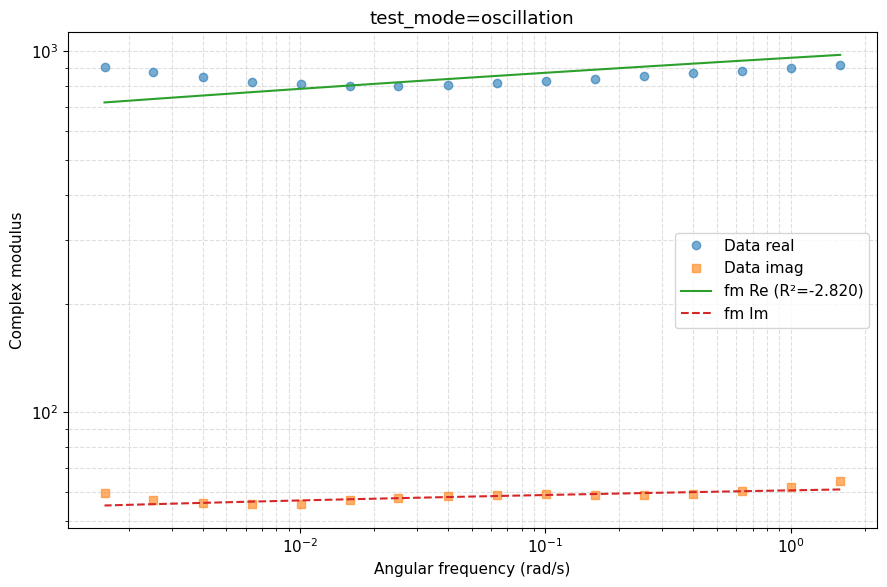

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<04:56,  2.36it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   6%|▌         | 42/700 [00:00<00:06, 104.66it/s, 3 steps of size 8.87e-04. acc. prob=0.90]

warmup:  11%|█▏        | 80/700 [00:00<00:03, 176.73it/s, 31 steps of size 1.60e-03. acc. prob=0.94]

warmup:  16%|█▌        | 111/700 [00:00<00:03, 191.84it/s, 191 steps of size 2.52e-03. acc. prob=0.94]

warmup:  20%|█▉        | 138/700 [00:00<00:02, 197.63it/s, 1023 steps of size 2.33e-03. acc. prob=0.95]

warmup:  24%|██▍       | 170/700 [00:00<00:02, 227.06it/s, 319 steps of size 1.26e-02. acc. prob=0.96] 

sample:  29%|██▉       | 205/700 [00:01<00:01, 254.03it/s, 127 steps of size 9.22e-03. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [00:01<00:01, 294.79it/s, 511 steps of size 9.22e-03. acc. prob=0.98]

sample:  40%|████      | 281/700 [00:01<00:01, 309.25it/s, 255 steps of size 9.22e-03. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [00:01<00:01, 350.39it/s, 511 steps of size 9.22e-03. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [00:01<00:00, 368.87it/s, 255 steps of size 9.22e-03. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [00:01<00:00, 380.59it/s, 511 steps of size 9.22e-03. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:01<00:00, 385.51it/s, 255 steps of size 9.22e-03. acc. prob=0.99]

sample:  71%|███████   | 497/700 [00:01<00:00, 407.23it/s, 71 steps of size 9.22e-03. acc. prob=0.99] 

sample:  77%|███████▋  | 539/700 [00:01<00:00, 401.31it/s, 511 steps of size 9.22e-03. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [00:02<00:00, 441.74it/s, 511 steps of size 9.22e-03. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [00:02<00:00, 447.39it/s, 511 steps of size 9.22e-03. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [00:02<00:00, 432.50it/s, 223 steps of size 9.22e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:02<00:00, 305.03it/s, 511 steps of size 9.22e-03. acc. prob=0.99]

Dataset 0: Bayesian inference complete for fm


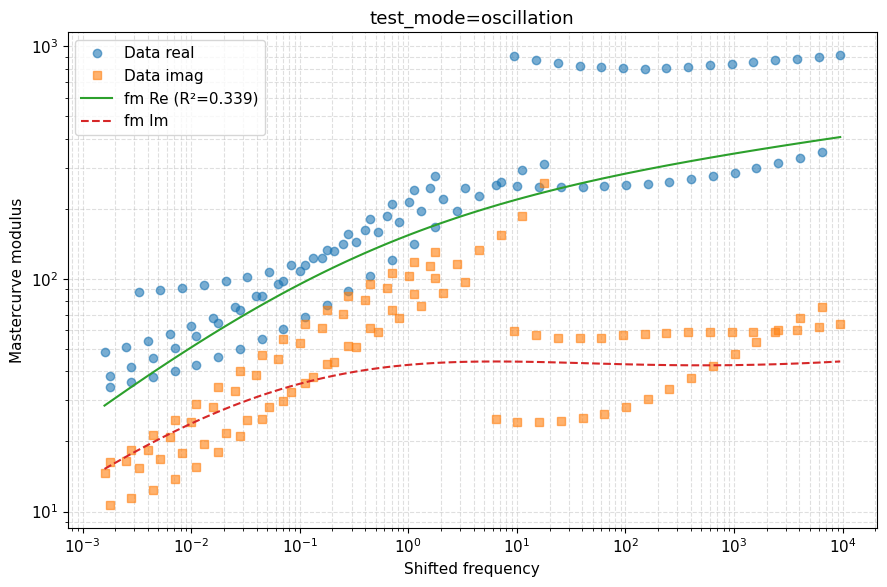

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<03:10,  3.68it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▎         | 26/700 [00:00<00:07, 87.09it/s, 1023 steps of size 2.50e-04. acc. prob=0.85]

warmup:   6%|▌         | 41/700 [00:00<00:08, 78.88it/s, 447 steps of size 1.19e-03. acc. prob=0.90] 

warmup:   8%|▊         | 58/700 [00:00<00:06, 100.16it/s, 255 steps of size 4.13e-03. acc. prob=0.93]

warmup:  13%|█▎        | 93/700 [00:00<00:03, 165.23it/s, 127 steps of size 6.40e-03. acc. prob=0.95]

warmup:  18%|█▊        | 123/700 [00:00<00:02, 201.05it/s, 159 steps of size 2.62e-02. acc. prob=0.95]

warmup:  21%|██        | 147/700 [00:01<00:02, 201.59it/s, 255 steps of size 3.30e-02. acc. prob=0.96]

warmup:  24%|██▍       | 170/700 [00:01<00:02, 205.03it/s, 255 steps of size 2.08e-02. acc. prob=0.96]

warmup:  28%|██▊       | 193/700 [00:01<00:02, 202.82it/s, 255 steps of size 2.25e-02. acc. prob=0.96]

sample:  31%|███       | 218/700 [00:01<00:02, 215.18it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [00:01<00:01, 230.58it/s, 255 steps of size 2.26e-02. acc. prob=0.98]

sample:  39%|███▉      | 273/700 [00:01<00:01, 242.34it/s, 255 steps of size 2.26e-02. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [00:01<00:01, 235.58it/s, 127 steps of size 2.26e-02. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [00:01<00:01, 250.26it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  50%|█████     | 353/700 [00:01<00:01, 240.17it/s, 127 steps of size 2.26e-02. acc. prob=0.99]

sample:  55%|█████▍    | 383/700 [00:01<00:01, 253.08it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [00:02<00:01, 274.18it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  63%|██████▎   | 444/700 [00:02<00:00, 257.71it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [00:02<00:00, 250.24it/s, 95 steps of size 2.26e-02. acc. prob=0.99] 

sample:  71%|███████   | 498/700 [00:02<00:00, 253.66it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [00:02<00:00, 260.29it/s, 191 steps of size 2.26e-02. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [00:02<00:00, 252.57it/s, 127 steps of size 2.26e-02. acc. prob=0.99]

sample:  83%|████████▎ | 584/700 [00:02<00:00, 265.27it/s, 127 steps of size 2.26e-02. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [00:02<00:00, 268.42it/s, 255 steps of size 2.26e-02. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [00:02<00:00, 262.03it/s, 71 steps of size 2.26e-02. acc. prob=0.99] 

sample:  95%|█████████▌| 666/700 [00:03<00:00, 234.47it/s, 127 steps of size 2.26e-02. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [00:03<00:00, 236.56it/s, 63 steps of size 2.26e-02. acc. prob=0.99] 

sample: 100%|██████████| 700/700 [00:03<00:00, 215.19it/s, 79 steps of size 2.26e-02. acc. prob=0.99]

Dataset 1: Bayesian inference complete for fm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'tau\n0'}>]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)


--- Diagnostics for dataset 1 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'tau\n0'}>]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)